In [108]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from P02_MSIE.T01_prototype_class.DE_IM_VRPTW_classV4 import VRPTW

In [109]:
class AIMH_ENV(gym.Env):
    def __init__(self, vrp):
        super().__init__()
        self.action_space = spaces.Box(
            low = np.array([0, 0, 0], dtype=np.float32), 
            high= np.array([5, 5, 1], dtype=np.float32), 
            shape=(3,),
            dtype=np.float32,
        )
            # order = [
        #     "best_solution",
        #     "F",
        #     "CR",
        #     "MG",
        #     "percent_convergence",
        #     "std_pop",
        #     "count_total_iteration",
        # ]
        self.observation_space = gym.spaces.Box(
            low=np.array([-2, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([2, 10, 10, 1, 1, 1, 1e5], dtype=np.float32),
            shape=(7,),  # 7 features
            dtype=np.float64,
        )
        self.vrp = vrp
        pass


    def _get_obs(self):
        
        state = self.vrp.get_current_state()
        obs = np.array(
            [
                np.float64(state["best_solution"]),
                np.float64(state["F"]),
                np.float64(state["CR"]),
                np.float64(state["MG"]),
                np.float64(state["percent_convergence"]),
                np.float64(state["std_pop"]),
                np.float64(state["count_total_iteration"]),
            ],
            dtype=np.float32,
        )
        
        return obs
    
    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info in addition to the observation
        """
        return self.vrp.get_info()
    

    def reset(self, seed=None, options=None):
        np.random.seed(seed or 42)
        self.vrp.reset()
        super().reset(seed=seed)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        self.vrp.action(action)
        self.vrp.evolve()
        reward = self.vrp.get_reward()
        if self.vrp.is_terminated():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

    

In [110]:
AIMH_ENV(vrp=None).action_space.sample()

array([2.9708636 , 4.460742  , 0.29559642], dtype=float32)

In [111]:
distance = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="distance"
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="vehicle"
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"../../Source/rl_meta_test_data.xlsx", sheet_name="customer"
).iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
interval_it = 1
patience = 100
population_size = 4
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5

vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
    interval_it=interval_it,
    patience=patience,
)

In [112]:
# TODO: Fix the environment to pass the checks
# UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
#   logger.warn(f"{pre} is not within the observation space.")
# Environment has issues: Deterministic step observations are not equivalent for the same seed and action


from gymnasium.utils.env_checker import check_env

env = AIMH_ENV(vrp=vrptw)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: The first element returned by `env.reset()` is not within the observation space.


c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\env_checker.py:333: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(


In [113]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [114]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data_array = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data_added = {**info, "reward": reward, "action": action}
    data_array.append(data_added)

df = pd.DataFrame.from_dict(data_array)
display(df)

,F,CR,MG,best_solution,percent_convergence,std_pop,count_total_iteration,patience_remaining,reward,action
0,1,0.568696,0.975965,65.009194,0.000000,2.000544,1,100,0.000000,"[2.4908295, 0.56869614, 0.9759653]"
1,1,0.412803,0.979343,62.237652,0.000000,2.595074,2,100,2.771542,"[2.4963408, 0.4128027, 0.9793426]"
2,1,0.454933,0.977287,62.237652,0.000000,1.604755,3,99,0.000000,"[2.6253633, 0.4549329, 0.9772872]"
3,1,0.377341,0.979071,61.763196,0.000000,1.924214,4,100,0.474456,"[2.7213435, 0.3773412, 0.9790709]"
4,1,0.378651,0.980046,61.199780,0.000000,2.072279,5,100,0.563416,"[2.8329718, 0.37865147, 0.9800463]"
...,...,...,...,...,...,...,...,...,...,...
126,1,0.012546,0.952006,54.710474,55.463932,3.288739,127,4,0.000000,"[4.99994, 0.012546331, 0.9520061]"
127,1,0.011570,0.951630,54.710474,55.463932,3.288739,128,3,0.000000,"[4.999941, 0.011569858, 0.95163]"
128,1,0.010715,0.951052,54.710474,55.463932,3.288739,129,2,0.000000,"[4.999942, 0.01071468, 0.95105225]"
129,1,0.009923,0.950467,54.710474,54.163369,3.288739,130,1,0.000000,"[4.9999423, 0.009922832, 0.9504668]"


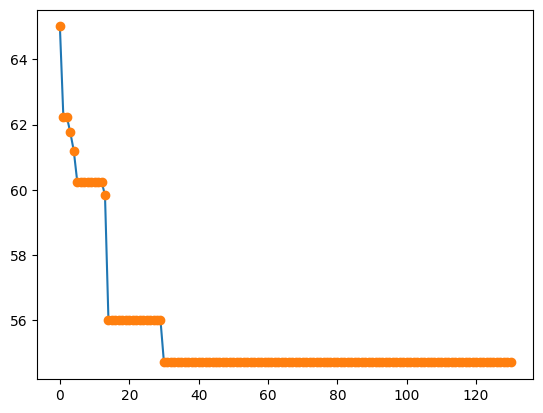

In [115]:
import matplotlib.pyplot as plt
plt.plot(env.vrp.global_solution_history)
x = np.arange(0,len(env.vrp.global_solution_history), interval_it)
y = np.array(env.vrp.global_solution_history)[x]
plt.plot(x, y, marker='o', linestyle='')
